**🚀 Predicting the variance-covariance matrix for next quarter**

- 🔍 *Use CNN model* to predict next quarter's **covariances**.
- 📉 *Currently uses daily returns to generate enough sample data* with a 63 day rolling window for **sufficient samples**.
- 🧠 *Trains* **Model** from **2018-07-01** to **2021-12-31** using the **CNN**


**Imports and Generate Matrices**

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:

# SPDR Sector ETFs
tickers = ["XLF", "XLK", "XLE", "XLY", "XLP", "XLV", "XLI", "XLU", "XLRE", "XLB", "XLC"]

# Dates
start_train, end_train = "2018-07-01", "2021-12-31"
start_test, end_test = "2022-01-01", "2024-12-31"

# Download and clean data
def get_cleaned_prices(tickers, start, end, threshold=0.05):
    data = yf.download(tickers, start=start, end=end, progress=False, auto_adjust=False)['Adj Close']
    data = data.ffill().bfill().dropna()
    valid_cols = data.isna().mean() < threshold
    return data.loc[:, valid_cols]

# Generate daily rolling 63-day covariance matrices
def generate_cov_matrices(prices, window=63):
    log_returns = np.log(prices / prices.shift(1)).dropna()
    cov_matrices = []
    dates = []

    for i in range(window, len(log_returns)):
        window_returns = log_returns.iloc[i - window:i]
        cov_matrix = window_returns.cov().values
        cov_matrices.append(cov_matrix)
        dates.append(log_returns.index[i])

    return np.array(cov_matrices), dates

# Fetch prices
prices_train = get_cleaned_prices(tickers, start_train, end_train)
prices_test = get_cleaned_prices(tickers, start_test, end_test)

# Keep only common tickers
common_tickers = sorted(set(prices_train.columns) & set(prices_test.columns))
prices_train = prices_train[common_tickers]
prices_test = prices_test[common_tickers]

# Generate daily rolling cov matrices
cov_train, train_dates = generate_cov_matrices(prices_train)
cov_test, test_dates = generate_cov_matrices(prices_test)

# Predict 1 quarter ahead (63 trading days)
prediction_horizon = 63

X_train = cov_train[:-prediction_horizon]
y_train = cov_train[prediction_horizon:]

X_test = cov_test[:-prediction_horizon]
y_test = cov_test[prediction_horizon:]

# Shapes
print("Final tickers used:", common_tickers)
print("Train cov matrices shape:", cov_train.shape)
print("Test cov matrices shape:", cov_test.shape)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


Final tickers used: ['XLB', 'XLC', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLRE', 'XLU', 'XLV', 'XLY']
Train cov matrices shape: (818, 11, 11)
Test cov matrices shape: (688, 11, 11)
X_train shape: (755, 11, 11)
y_train shape: (755, 11, 11)
X_test shape: (625, 11, 11)
y_test shape: (625, 11, 11)


**Visualize Random Matrix**

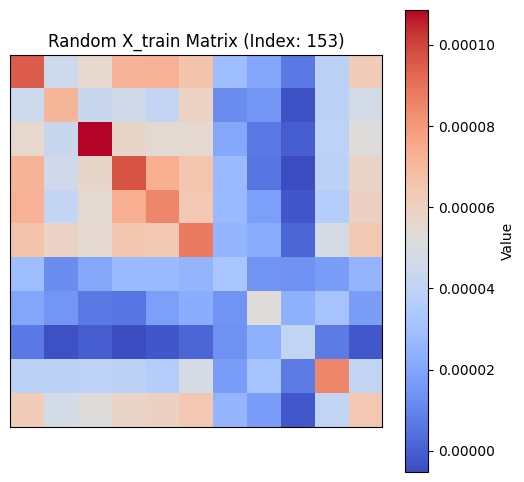

In [3]:

# Select a random index from X_train
random_index = random.randint(0, X_train.shape[0] - 1)
random_matrix = X_train[random_index]

# Plot the heatmap
plt.figure(figsize=(6, 6))
plt.imshow(random_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Value')
plt.title(f'Random X_train Matrix (Index: {random_index})')
plt.xticks([])
plt.yticks([])
plt.show()

**Normalize Matrices**

In [4]:
# Normalize covariance matrices before training (optional)
X_train_norm = X_train / np.max(X_train, axis=(1, 2), keepdims=True)
y_train_norm = y_train / np.max(y_train, axis=(1, 2), keepdims=True)

# Normalize covariance matrices for test data
X_test_norm = X_test / np.max(X_test, axis=(1, 2), keepdims=True)
y_test_norm = y_test / np.max(y_test, axis=(1, 2), keepdims=True)

**Initial Model**

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models, losses
import numpy as np

# Assuming you already have X_train, y_train as numpy arrays
# Shape: (755, 11, 11)

# Add channel dimension (CNNs expect 4D input: [batch, height, width, channels])
X_train_cnn = X_train_norm[..., np.newaxis]
y_train_cnn = y_train_norm[..., np.newaxis]

# Custom Euclidean (L2) distance loss
def euclidean_distance_loss(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(y_pred - y_true), axis=[1, 2, 3])))

# Build the CNN model
def build_cnn_model(input_shape, filters1=32, filters2=64, kernel_size=(3,3)):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(filters1, kernel_size=kernel_size, padding='same', activation='relu'),
        layers.Conv2D(filters2, kernel_size=kernel_size, padding='same', activation='relu'),
        layers.Conv2D(1, kernel_size=(3, 3), padding='same', activation=None),
    ])
    return model


# Initialize model
input_shape = (11, 11, 1)
model = build_cnn_model(input_shape)
model.compile(optimizer='adam', loss=euclidean_distance_loss)

# Train the model
history = model.fit(X_train_cnn, y_train_cnn, epochs=30, batch_size=16, verbose=1)

# Evaluate on training data
train_loss = model.evaluate(X_train_cnn, y_train_cnn, verbose=0)
print(f"Training Euclidean Loss: {train_loss:.6f}")

KeyboardInterrupt: 

**Predict on Train Data**

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


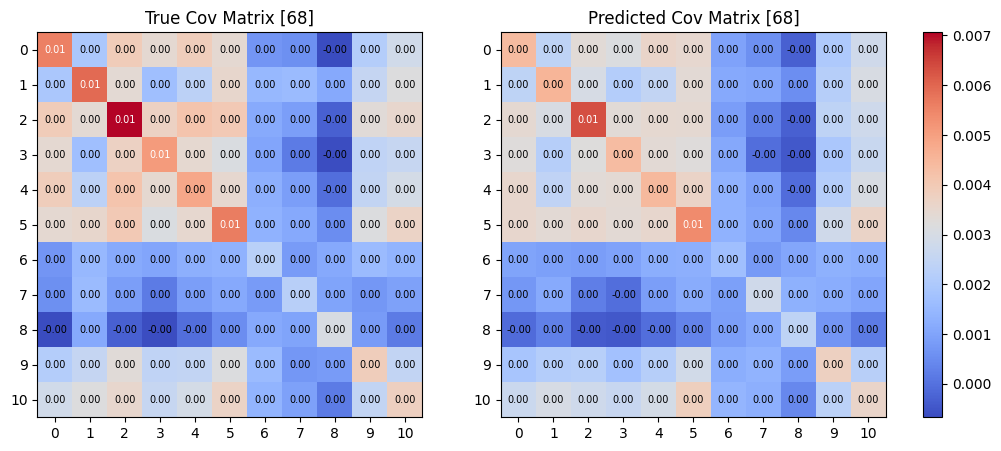

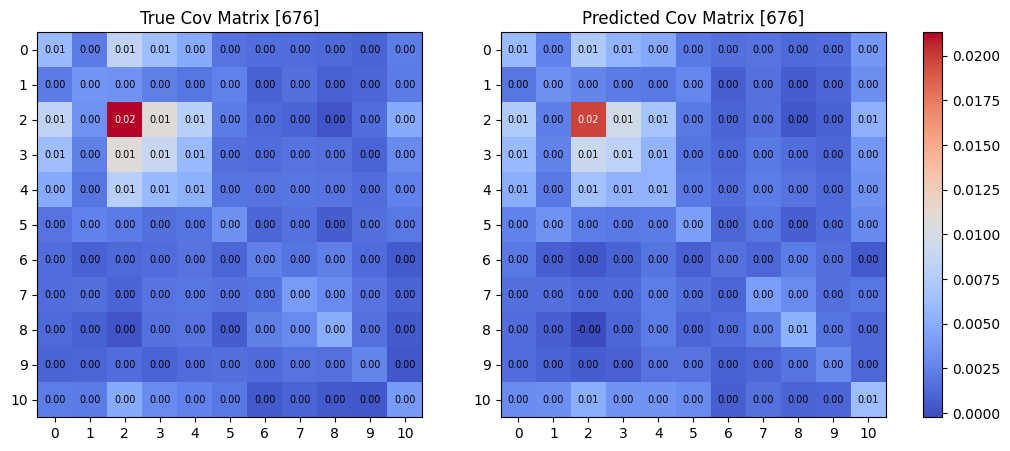

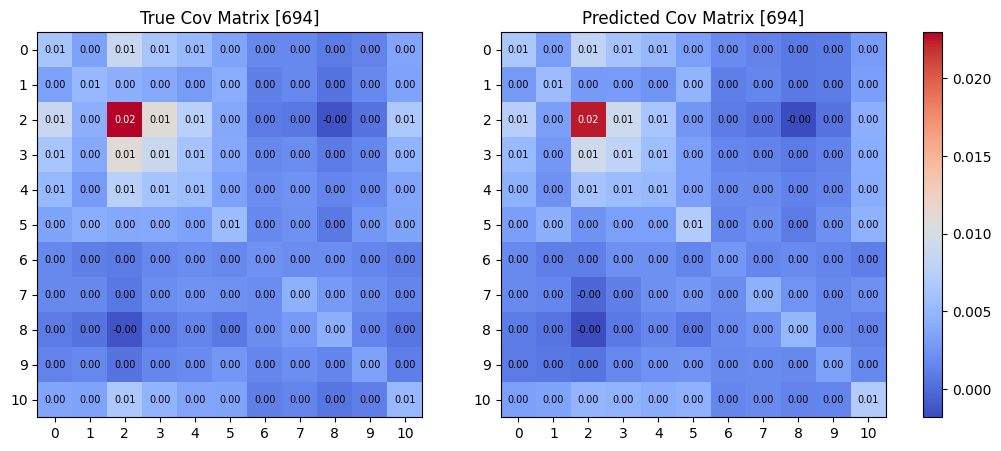

In [25]:
# Predict on training data
y_train_pred_cnn = model.predict(X_train_cnn)

# Optional: squeeze to remove single channel for easier matrix operations
y_train_pred_flat = y_train_pred_cnn.squeeze()
y_train_true_flat = y_train_cnn.squeeze()

# ------------------------------
# Denormalize the predictions and targets
# ------------------------------

# Keep y_train_max shaped as (755, 1, 1) so it broadcasts correctly
y_train_max = np.max(y_train, axis=(1, 2), keepdims=True)  # shape: (755, 1, 1)

# Denormalize
y_train_pred_denorm = y_train_pred_flat * y_train_max  # shape: (755, 11, 11)
y_train_true_denorm = y_train_true_flat * y_train_max

#Scale for Quarterly covariance matrix
y_train_pred_scaled = y_train_pred_denorm * 63
y_train_true_scaled = y_train_true_denorm * 63

# ------------------------------
# Compare 3 random predictions visually
# ------------------------------

def plot_train_heatmaps(true_matrix, pred_matrix, idx):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    cmap = 'coolwarm'

    vmin = min(true_matrix.min(), pred_matrix.min())
    vmax = max(true_matrix.max(), pred_matrix.max())

    matrices = [true_matrix, pred_matrix]
    titles = [f'True Cov Matrix [{idx}]', f'Predicted Cov Matrix [{idx}]']

    for ax, mat, title in zip(axs, matrices, titles):
        im = ax.imshow(mat, cmap=cmap, vmin=vmin, vmax=vmax)
        ax.set_title(title)
        ax.set_xticks(range(mat.shape[1]))
        ax.set_yticks(range(mat.shape[0]))

        # Annotate each cell with numeric value
        for i in range(mat.shape[0]):
            for j in range(mat.shape[1]):
                value = round(mat[i, j], 2)
                color = 'white' if abs(value) > (vmax - vmin) / 2 else 'black'
                ax.text(j, i, f"{value:.2f}", ha='center', va='center', color=color, fontsize=7)

    # Add shared colorbar
    fig.colorbar(im, ax=axs, fraction=0.046, pad=0.04)
    plt.show()

# Example usage: visualize 3 random samples
train_sample_indices = random.sample(range(len(y_train_true_denorm)), 3)
for idx in train_sample_indices:
    plot_train_heatmaps(y_train_true_scaled[idx], y_train_pred_scaled[idx], idx)


**Param Grid**

In [20]:
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.model_selection import ParameterGrid

param_grid = {
    'filters1': [16, 32],
    'filters2': [32, 64],
    'kernel_size': [(3, 3), (5, 5)],
    'optimizer': ['adam', 'rmsprop'],
    'learning_rate': [0.001, 0.0005],
    'batch_size': [16, 32]
}

**Grid Search**

In [21]:
import tensorflow.keras.backend as K

input_shape = (11, 11, 1)
X = X_train_cnn
y = y_train_cnn

results = []
grid = list(ParameterGrid(param_grid))

for i, params in enumerate(grid):
    print(f"\nRunning config {i+1}/{len(grid)}: {params}")

    # Build and compile model
    model = build_cnn_model(input_shape, params['filters1'], params['filters2'], params['kernel_size'])

    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'])
    else:
        optimizer = RMSprop(learning_rate=params['learning_rate'])

    model.compile(optimizer=optimizer, loss=euclidean_distance_loss)

    # Train model
    history = model.fit(X, y, epochs=10, batch_size=params['batch_size'], verbose=0)

    # Evaluate loss
    loss = model.evaluate(X, y, verbose=0)

    results.append({
        'params': params,
        'train_loss': loss
    })

    # Clear memory
    K.clear_session()



Running config 1/64: {'batch_size': 16, 'filters1': 16, 'filters2': 32, 'kernel_size': (3, 3), 'learning_rate': 0.001, 'optimizer': 'adam'}


Running config 2/64: {'batch_size': 16, 'filters1': 16, 'filters2': 32, 'kernel_size': (3, 3), 'learning_rate': 0.001, 'optimizer': 'rmsprop'}

Running config 3/64: {'batch_size': 16, 'filters1': 16, 'filters2': 32, 'kernel_size': (3, 3), 'learning_rate': 0.0005, 'optimizer': 'adam'}

Running config 4/64: {'batch_size': 16, 'filters1': 16, 'filters2': 32, 'kernel_size': (3, 3), 'learning_rate': 0.0005, 'optimizer': 'rmsprop'}

Running config 5/64: {'batch_size': 16, 'filters1': 16, 'filters2': 32, 'kernel_size': (5, 5), 'learning_rate': 0.001, 'optimizer': 'adam'}

Running config 6/64: {'batch_size': 16, 'filters1': 16, 'filters2': 32, 'kernel_size': (5, 5), 'learning_rate': 0.001, 'optimizer': 'rmsprop'}

Running config 7/64: {'batch_size': 16, 'filters1': 16, 'filters2': 32, 'kernel_size': (5, 5), 'learning_rate': 0.0005, 'optimizer': 'adam'}


**Results**

In [22]:
sorted_results = sorted(results, key=lambda x: x['train_loss'])
for rank, result in enumerate(sorted_results[:5], 1):
    print(f"#{rank} Loss: {result['train_loss']:.6f} | Params: {result['params']}")

#1 Loss: 0.778338 | Params: {'batch_size': 16, 'filters1': 32, 'filters2': 64, 'kernel_size': (5, 5), 'learning_rate': 0.001, 'optimizer': 'adam'}
#2 Loss: 0.800067 | Params: {'batch_size': 16, 'filters1': 32, 'filters2': 64, 'kernel_size': (5, 5), 'learning_rate': 0.001, 'optimizer': 'rmsprop'}
#3 Loss: 0.824180 | Params: {'batch_size': 16, 'filters1': 16, 'filters2': 64, 'kernel_size': (5, 5), 'learning_rate': 0.001, 'optimizer': 'adam'}
#4 Loss: 0.833730 | Params: {'batch_size': 16, 'filters1': 16, 'filters2': 64, 'kernel_size': (5, 5), 'learning_rate': 0.001, 'optimizer': 'rmsprop'}
#5 Loss: 0.841174 | Params: {'batch_size': 16, 'filters1': 32, 'filters2': 32, 'kernel_size': (5, 5), 'learning_rate': 0.001, 'optimizer': 'adam'}


**Train best model with 30 epochs**

In [23]:
# Best parameters from grid search
best_params = {
    'filters1': 32,
    'filters2': 64,
    'kernel_size': (5, 5),
    'learning_rate': 0.001,
    'batch_size': 16,
    'optimizer': 'adam'
}

# Build the CNN model with the best parameters
model = build_cnn_model(input_shape, best_params['filters1'], best_params['filters2'], best_params['kernel_size'])

# Compile the model with Adam optimizer and the best learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate'])
model.compile(optimizer=optimizer, loss=euclidean_distance_loss)

# Retrain the model on the full training data
history = model.fit(X_train_cnn, y_train_cnn, epochs=30, batch_size=best_params['batch_size'], verbose=1)

Epoch 1/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.9415
Epoch 2/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2639
Epoch 3/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0702
Epoch 4/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9998
Epoch 5/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9983
Epoch 6/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9188
Epoch 7/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8786
Epoch 8/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9729
Epoch 9/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8115
Epoch 10/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8092
Epoch 11/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7773
Epoch 12/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8042
Epoch 13/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7210
Epoch 14/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7076
Epoch 15/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7108
Epoch 16/30
48/48 ━

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


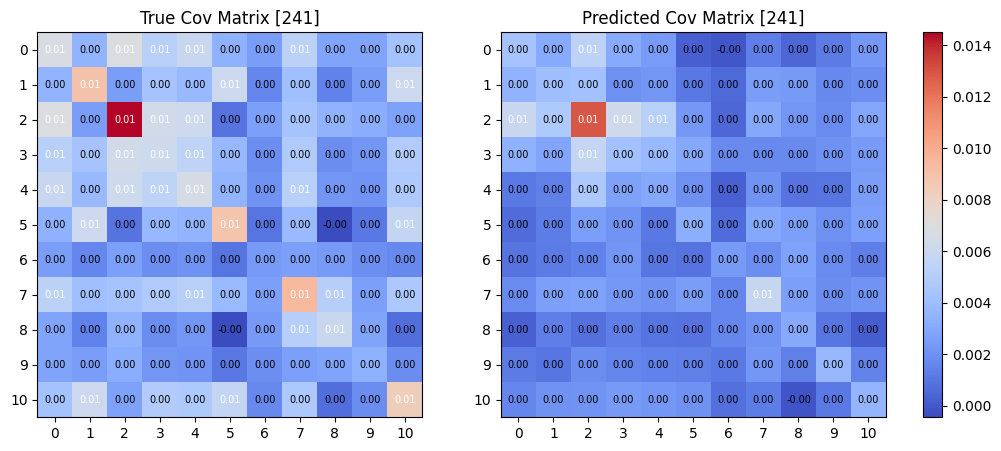

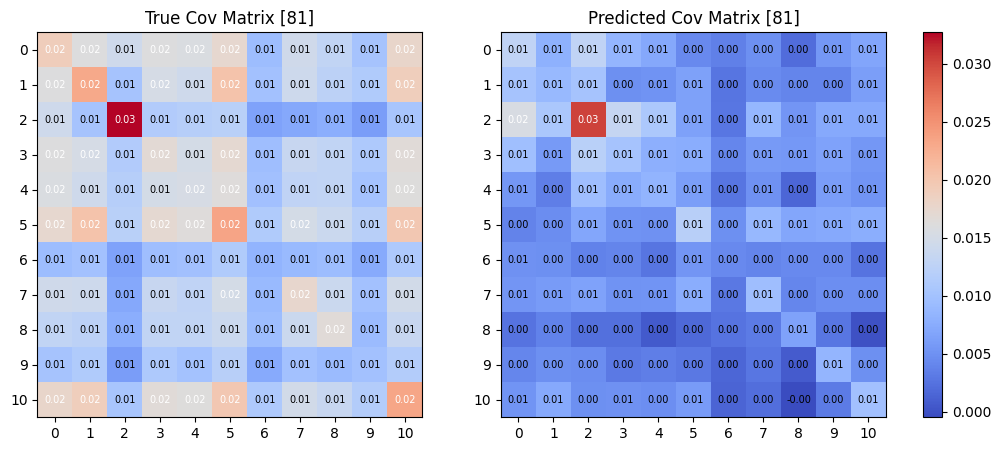

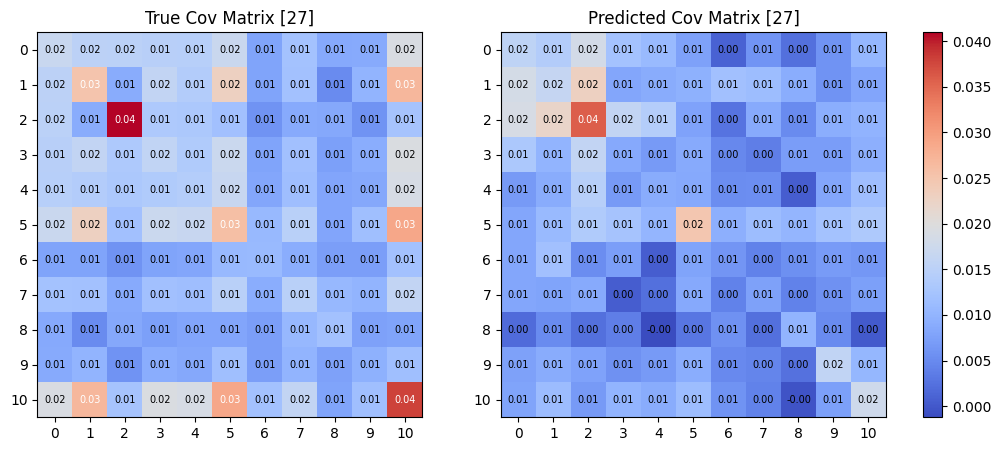

In [26]:
import matplotlib.pyplot as plt
import random
from sklearn.metrics import mean_squared_error

# Prepare test data for prediction
X_test_norm_cnn = X_test_norm[..., np.newaxis]
y_test_norm_cnn = y_test_norm[..., np.newaxis]

# Predict
y_test_pred_norm_cnn = model.predict(X_test_norm_cnn)

# Optional: squeeze to remove single channel for easier matrix operations
y_test_pred_flat = y_test_pred_norm_cnn.squeeze()
y_test_true_flat = y_test_norm_cnn.squeeze()

# Keep y_train_max shaped as (755, 1, 1) so it broadcasts correctly
y_test_max = np.max(y_test, axis=(1, 2), keepdims=True)  # shape: (755, 1, 1)

# Denormalize
y_test_pred_denorm = y_test_pred_flat * y_test_max  # shape: (755, 11, 11)
y_test_true_denorm = y_test_true_flat * y_test_max

#Scale for Quarterly covariance matrix
y_test_pred_scaled = y_test_pred_denorm * 63
y_test_true_scaled = y_test_true_denorm * 63


# Example usage: visualize 3 random samples
train_sample_indices = random.sample(range(len(y_test_true_denorm)), 3)
for idx in train_sample_indices:
    plot_train_heatmaps(y_test_true_scaled[idx], y_test_pred_scaled[idx], idx)